In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# 데이터 입력
df = pd.read_csv('../dataset/glass.csv')


1 Physical GPUs, 1 Logical GPUs


In [17]:

# 데이터 분류
dataset = df.copy()
Y_obj = dataset.pop('Type')
#dataset.pop('Ba')
#dataset.pop('Fe')
#dataset.pop('K')
X = dataset.copy()
#Y_obj =

# 문자열을 숫자로 변환
e = LabelEncoder()
e.fit(Y_obj)
Y = e.transform(Y_obj)
Y_encoded = tf.keras.utils.to_categorical(Y)

print(Y_encoded)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [28]:
from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler

# 전체 데이터에서 학습 데이터와 테스트 데이터(0.1)로 구분
X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y_encoded, test_size=0.1, shuffle=True, random_state=1)  ## shuffle=True로 하면 데이터를 섞어서 나눔
## 학습 셋에서 학습과 검증 데이터(0.2)로 구분
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.2, shuffle=True, random_state=1)  ## shuffle=True로 하면 데이터를 섞어서 나눔

#dataset_stats = X_train.describe()
#dataset_stats = dataset_stats.transpose()
#X_samp, y_samp = RandomOverSampler(random_state=0).fit_resample(X_train, Y_train)
dataset_stats = X_samp.describe()
dataset_stats = dataset_stats.transpose()

def standard_norm(x):
  return (x - dataset_stats['mean']) / dataset_stats['std']

normed_train_data = standard_norm(X_samp)
normed_val_data = standard_norm(X_valid)
normed_test_data = standard_norm(X_test)

/home/dalu/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [25]:

# 모델의 설정
input_Layer = tf.keras.layers.Input(shape=(6,))
x1 = tf.keras.layers.Dense(30, activation='sigmoid')(input_Layer)
x2 = tf.keras.layers.Dense(10, activation='sigmoid')(x1)
Out_Layer = tf.keras.layers.Dense(6, activation='softmax')(x2)
model = tf.keras.models.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()
# 모델 컴파일
loss=tf.keras.losses.categorical_crossentropy
optimizer =tf.keras.optimizers.SGD(learning_rate=0.1)
metrics=tf.keras.metrics.categorical_accuracy
model.compile(loss=loss,
             optimizer=optimizer,
             metrics=[metrics])
## model fit은 histoy를 반환한다. 훈련중의 발생하는 모든 정보를 담고 있는 딕셔너리.
#result = model.fit(X_train, Y_train, epochs=2000, batch_size=50, validation_data=(X_valid,Y_valid)) 
result=  model.fit(normed_train_data, Y_train, epochs=2000, batch_size=50, validation_data=(normed_val_data, Y_valid)) 
## histoy는 딕셔너리이므로 keys()를 통해 출력의 key(카테고리)를 확인하여 무엇을 받고 있는지 확인.
print(result.history.keys())


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 30)                210       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 66        
Total params: 586
Trainable params: 586
Non-trainable params: 0
_________________________________________________________________


ValueError: Data cardinality is ambiguous:
  x sizes: 330
  y sizes: 153
Make sure all arrays contain the same number of samples.

1/1 [==============================] - 0s 21ms/step - loss: 0.9314 - categorical_accuracy: 0.7273

 Test Accuracy: 0.7273


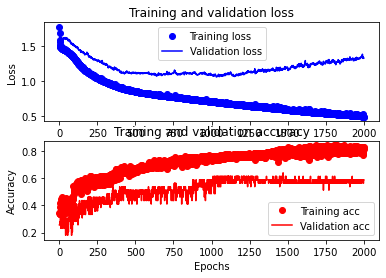

In [21]:
### result에서 loss와 val_loss의 key를 가지는 값들만 추출
loss = result.history['loss']
val_loss = result.history['val_loss']
### loss와 val_loss를 그래프화
epochs = range(1, len(loss) + 1)
plt.subplot(211)  ## 2x1 개의 그래프 중에 1번째
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
### result에서 binary_accuracy와 val_binary_accuracy key를 가지는 값들만 추출
acc = result.history['categorical_accuracy']
val_acc = result.history['val_categorical_accuracy']
### binary_accuracy와 val_binary_accuracy key를 그래프화
plt.subplot(212)  ## 2x1 개의 그래프 중에 2번째
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# model.evalueate를 통해 테스트 데이터로 정확도 확인하기.
## model.evaluate(X_test, Y_test)의 리턴값은 [loss, binary_acuuracy ]  -> 위 model.compile에서 metrics=[ keras.metrics.binary_accuracy]옵션을 주어서 binary acuuracy 출력됨.
print("\n Test Accuracy: %.4f" % (model.evaluate(normed_test_data, Y_test)[1]))
## 그래프 띄우기
plt.show()